     ML Project 2020

Project requirement: The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. You must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.


import the required packages for the program

In [1]:
# For data frames.
import pandas as pd
import seaborn as sns

# For numerical arrays.
import numpy as np

# For plotting
import matplotlib.pyplot as plt
#%matplotline inline

#For maths
import math as m

# For linear regression.
from sklearn import linear_model

# For evaluating model performance.
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

# For splitting data into train / test sets.
from sklearn.model_selection import train_test_split
#import sklearn.model_selection as skms

from scipy.optimize import curve_fit
from scipy import stats
import sklearn.preprocessing as skpp
import sklearn.metrics as skme
import tensorflow.keras as kr
from keras.models import model_from_json
from tensorflow.keras.models import Sequential 

In [2]:
plt.rcParams['figure.figsize'] = (8.0, 6.0) 

<b>PowerProduction Dataset</b>


In [3]:
# File provided as a txt file. I saved it as a csv file.
Power_data = pd.read_csv("data\powerproduction.csv")

# Make a copy of the original dataset in case we need it later.
Power_data_copy = Power_data

# Size?
shape = Power_data.shape
print("Data frame shape", shape, "r,c")

# Check for NaNs, missing values etc
print(Power_data.count())

Data frame shape (500, 2) r,c
speed    500
power    500
dtype: int64


In [4]:
# Have a look at the data from our Power Production input
Power_data

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


Since the power column has zero output from the above we will check few lines from top and bottom of the file



In [5]:
# Print firdt 20 rows
Power_data.head(20)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [6]:
Power_data.tail(20)

,speed,power
480,23.974,94.270
481,24.024,105.992
482,24.049,93.524
483,24.174,95.869
484,24.199,101.419
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223
489,24.399,95.117


Looking at the raw data it is noted that wind speeds 0.275 and below generate no power, wind speeds 24.499 generate no power. Even from the above description the power for the low and high level wind speed power has taken zero value. So we will look at some more rows from the top to find the data for Power column.

In [7]:
# Look at some quick descriptive statistics of the numeric data.
print(Power_data.describe())

            speed       power
count  500.000000  500.000000
mean    12.590398   48.014584
std      7.224991   41.614572
min      0.000000    0.000000
25%      6.324750    5.288000
50%     12.550500   41.645500
75%     18.775250   93.537000
max     25.000000  113.556000


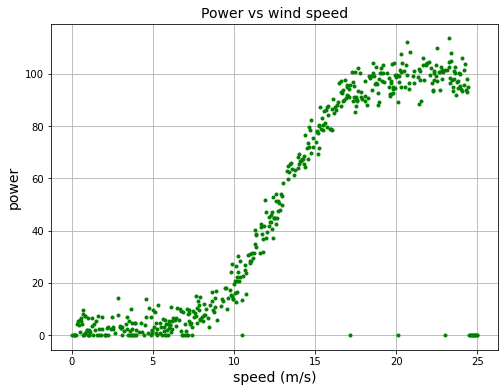

In [8]:
# Try plotting power as a function of wind speed to check for any obvious relationship between them.
plt.plot(Power_data['speed'], Power_data['power'],  '.g')
plt.title('Power vs wind speed', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power', fontsize='14')
plt.grid()

With the given data we can see that there is little power is generated until some threshold speed is achieved (about 7 m/s), then it increases nearly linearly in a range of wind speeds (8 - 17 m/s), before saturating above a certain wind speed (about 17 m/s). The plot would suggest there is a range of wind speeds where the power seems to increase linearly with wind speed. 

I would like to do some cleanup to remove the zero power just to make it clear while finding the promising model

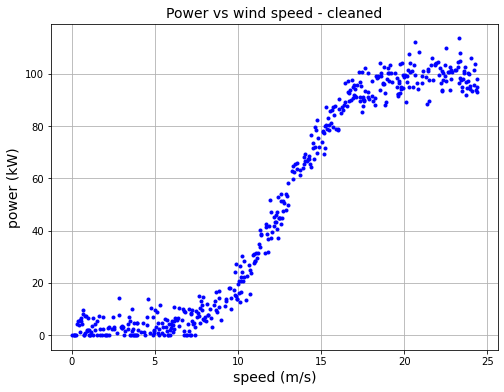

In [9]:
# Remove the rows with zero values to Power column from my existing dataset.
Power_data.drop(Power_data.loc[(Power_data.power == 0) & (Power_data.speed > 10)].index, inplace=True)

plt.plot(Power_data['speed'], Power_data['power'],  '.b')
plt.title('Power vs wind speed - cleaned', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.grid()

<b>Formula used in real life to calculate the Power of Wind</b>

In order to calculate the amount of energy the wind speed is very important to convert it to electricity. The energy content of the wind varies with the cube of the avereate  wind speed, e.g. if the wind speed is twice as high it contains 2^3 = 2x2x2 = eight times as much energy [1]



![Power_of_wind](images/Power_of_wind.jpg)


<b>Power Curve of a Wind Turbine</b>

The power curve of a wind turbine is a graph that indicates how large the electrical power output will be for the turbine at different wind speeds[2] At the same time this curve will not show how much power a wind turbine will produce at a certain average wind speed.

When the anemometer registers wind speeds higher than 25 mph (cut-out speed varies by turbine), it triggers the wind turbine to automatically shut off and resumes back to normal when the measurement of wind speed are at or below the turbine's cut-out speed[4]  

![Power_curve](images/Power_curve.jpg)

![Power_curve2](images/Wind_Power_curve.jpg)

The theoretical power curve for a turbine is specific to each turbine and site [3]. Based on the above graph  
 - The cut-in speed is the threshold wind speed that much be reached before the turbine will start to generate electricity. A typical value is about 4 m/s.
 - The rated output power is achieved at approximately 14 - 15 m/s.
 - The cut-out speed is the wind speed at which the turbine will stop producing electricity in order to avoid damage; typically 25 m/s.
 
While comparing this curve with the plot diagram on our cleaned dataset is nearly closer but we will start to apply some regression methods to find the best model for our Power production dataset.

## Prepare Dataset 

In order to prepare our dataset for investigations, it is better to remove unwanted results like zero output from it to find a best model. So that I am going to use the last cleaned dataset hear after.

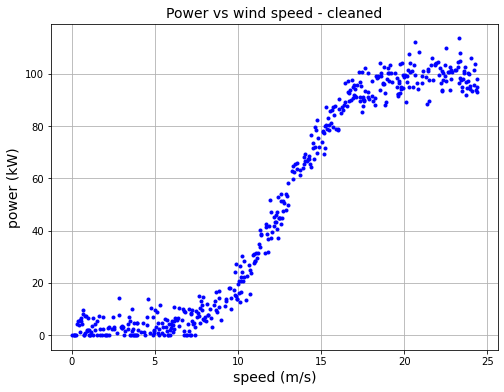

In [10]:
# Remove the rows with zero values to Power column from my existing dataset.
Cleaned_Power_Data =  Power_data

#Power_data.drop(Power_data.loc[(Power_data.power == 0) & (Power_data.speed > 10)].index, inplace=True)

plt.plot(Cleaned_Power_Data['speed'], Cleaned_Power_Data['power'],  '.b')
plt.title('Power vs wind speed - cleaned', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.grid()

### Applying Linear regression 

Linear regression uses the relationship between the data-points to draw a straight line through all them. This line can be used to predict future values. It is a very powerful technique and can be used to understand the factors that influence profitability.[5] 


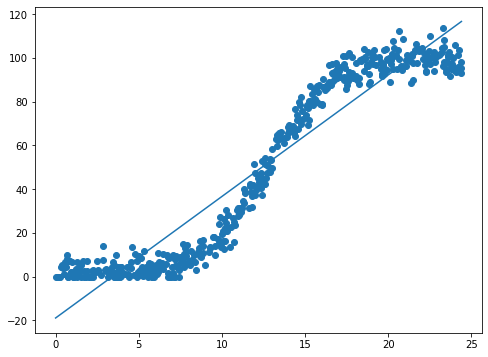

In [11]:
# https://www.w3schools.com/python/python_ml_linear_regression.asp
x = Power_data['speed'].tolist()
y = Power_data['power'].tolist()

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

From the above graph, you will a line straight in the middle of the data, means that there are large parts of the data untouched by the line where a linear prediction of the coordinates of speed to power would be very out of sync with where most of the data is. 

If we try to eliminate the data where speed and power are zero then we could get a good model with linear regression.

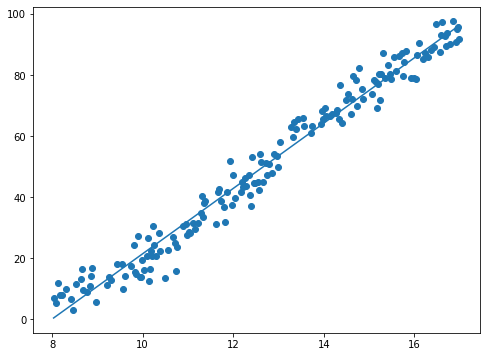

In [12]:
# https://www.w3schools.com/python/python_ml_linear_regression.asp

# Cleaniing the dataset by removing the zero values
cleansed_data = Power_data.loc[Power_data['power'] > 0 ]

Medium_set_data = cleansed_data.loc[(cleansed_data['speed'] > 8) & (cleansed_data['speed']<= 17)]

x = Medium_set_data['speed'].tolist()
y = Medium_set_data['power'].tolist()

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()


In [13]:
Medium_set_data.describe().round(2)

,speed,power
count,172.00,172.00
mean,12.66,49.93
std,2.58,27.97
min,8.03,3.00
25%,10.38,24.26
50%,12.55,47.31
75%,14.92,76.70
max,16.99,97.53


In [14]:
# Count low medium and high wind speed ranges. Code adapted from
# https://www.kite.com/python/answers/how-to-count-the-number-of-rows-in-a-pandas-dataframe-in-python
df_cnt = len(Power_data.index)

med_s_cnt = len(Medium_set_data.index)

# Print % of low medium and high wind speed ranges.
# Code adapted from https://pyformat.info/
print(f"Medium speed range: 8 to 18 m/s = {(med_s_cnt/df_cnt)*100:.1f}%")


Medium speed range: 8 to 18 m/s = 35.4%


<b> Summary plot of relationship for Medium Wind Speed range </b>

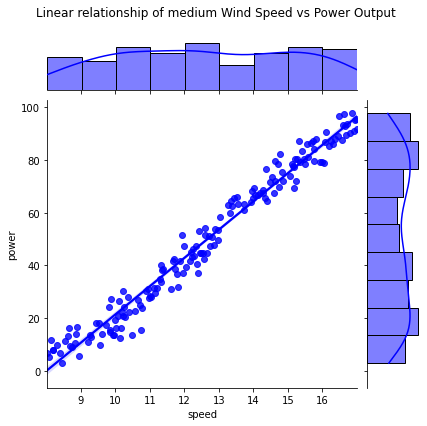

In [15]:
# Plot comparison of medium wind speed versus power output
# Code adapted from https://seaborn.pydata.org/tutorial/distributions.html#plotting-univariate-distributions 
# and https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot
plot = sns.jointplot(x="speed", y="power", kind="reg", color="b", height=6, data=Medium_set_data)

# Add Title adapted from https://stackoverflow.com/a/52096280
plt.subplots_adjust(top=0.90)
plt.suptitle("Linear relationship of medium Wind Speed vs Power Output", fontsize = 12)
# Display plot
plt.show()


<b> Display plot of cleaned dataset </b>

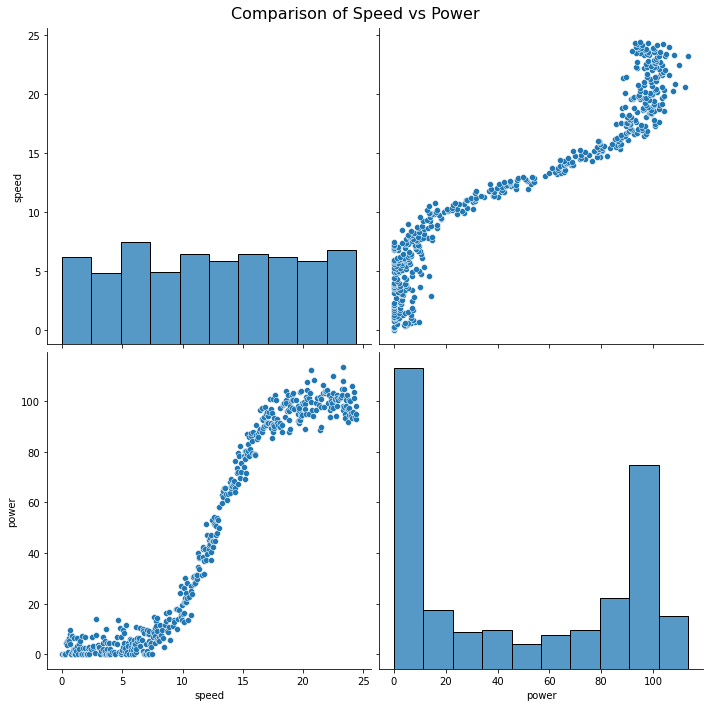

In [16]:
# Replot data comparison 
plot = sns.pairplot(Power_data, height=5)
# Add Title 
plt.subplots_adjust(top=0.95)
plt.suptitle("Comparison of Speed vs Power", fontsize = 16)
plt.show()

#### Splitting our Data Set into Training Data and Test Data

Using scikit-learn we can divide the Power Production data set into training data and test data. 

In [17]:
# Code adopted from https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/
#x =  Power_data.iloc[:, :-1].values
#y =  Power_data.iloc[:, :1].values

x = Power_data[["speed"]]
y = Power_data["power"]

print(x.shape)
print(y.shape)

#Split 70% of data into training set and 30% of data into test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

#Build the model
from sklearn.linear_model import LinearRegression
Linear_Reg_model = LinearRegression()

#Fit the model
Linear_Reg_model.fit(x_train, y_train)

#Print coefficient
print('Coefficients: \n',Linear_Reg_model.coef_)

#print intercept of the regression equation
print('Intercept: \n', Linear_Reg_model.intercept_)


# Make predictions from the model
y_pred = Linear_Reg_model.predict(x_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()



(486, 1)
(486,)
Coefficients: 
 [5.5504282]
Intercept: 
 -19.04656477876982


,Actual,Predicted
452,102.544,107.353337
279,68.616,60.263504
467,94.867,111.238636
128,10.262,16.925760
321,88.042,71.791743


<b>Evaluating the Algorithm</b>

The final step is to evaluate the performance of algorithm. This step is particularly important to compare how well different algorithms perform on a particular dataset. For regression algorithms, three evaluation metrics are commonly used:
 - Mean Absolute Error (MAE)
 - Mean Squared Error (MSE)
 - Root Mean Squared Error (RMSE)
 

In [18]:
# Code adopted from https://stackabuse.com/linear-regression-in-python-with-scikit-learn/
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 11.266761702328912
Mean Squared Error: 160.41515210744845
Root Mean Squared Error: 12.665510337426142


You can see that the value of root mean squared error is 12.29, which is around 25% of the mean value of the percentages of Power energy which is 49.39. From this result we can see the impact of zero values for Speed and Power. If we get less than around 10% of Mean value of the actual dataset then it would be a good mode;

<b>Apply Train test on Medium Power data set</b>

In [19]:
# Code adopted from https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/
#x =  Power_data.iloc[:, :-1].values
#y =  Power_data.iloc[:, :1].values

x = Medium_set_data[["speed"]]
y = Medium_set_data["power"]

print(x.shape)
print(y.shape)

#Split 70% of data into training set and 30% of data into test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

#Build the model
from sklearn.linear_model import LinearRegression
Linear_Reg_model = LinearRegression()

#Fit the model
Linear_Reg_model.fit(x_train, y_train)

#Print coefficient
print('Coefficients: \n',Linear_Reg_model.coef_)

#print intercept of the regression equation
print('Intercept: \n', Linear_Reg_model.intercept_)


# Make predictions from the model
y_pred = Linear_Reg_model.predict(x_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()


(172, 1)
(172,)
Coefficients: 
 [10.67203356]
Intercept: 
 -85.15103478573607


,Actual,Predicted
248,44.735,48.110648
316,86.611,86.305856
166,7.830,2.178216
172,13.113,6.991303
326,97.274,92.186147


<b>Evaluating the Algorithm</b>

In [20]:
# Code adopted from https://stackabuse.com/linear-regression-in-python-with-scikit-learn/
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 3.8285712898195476
Mean Squared Error: 22.15310374318937
Root Mean Squared Error: 4.706708376688465


From the result above we can see that the value of root mean squared error is 5.03, which is around 10% of the mean value of the percentages of Power energy which is 49.39.

From the above predictions and investigations it is clear that applying linear regression on a large set of data will not be good and it is quite good when there is no invalid data and a small set of data.

### Machine learning methods for wind turbine condition monitoring

The ML model selection step is particularly significant as it is the core functionality that learns from past data and generalizes into the future. Such models have been used for different tasks, including classification, regression, anomaly detection, synthesis and sampling, imputation of missing values, denoising, density estimation and many others. Several different models have been suggested for learning from data. Support vector machines (SVMs) and neural networks (NNs) are two common models that have been used in ML for diagnostics and prognostics.[6].


While searching for a good model that can fit into out dataset, I found that Neural network has a better performance than the other traditional models. Since Deep Neural Network models are capable of learning complex non-linear functions, it may achieve better performance. 

#### Deep Learning in Keras

Deep learning is one of the most interesting and promising areas of artificial intelligence(AI) and machine learning currently. [7] It is a subfield of machine learning, and Neural Networks make up the backbone of deep learning algorithms. 
A deep learning neuual network is just a neural network with many hidden layers.

- <b>Number of layers :</b>
    In this model I am going to use Dense layer.
- <b>Types of these layers :</b>
    Dense layers are the most common and popular type of layers and it's just a regular neural network layer where each of its neurons is connected to the neurons of the previous and next layers.
- <b>Number of units (neurons) in each Layer :</b>
    Each dense layer has an activation function that determines the output of its neurons based on the inputs and the weights of the synapses.
- <b>Activation Functions of each Layer :</b>
    There are also many types of activation functions are avilable and I am going to try Than and Sigmoid function in my model
- <b>Input and output size :</b>
    Neural network consisting of three layers: the input layer, a hidden layer with 50 neurons, and the output layer. The size of the input and output layers is determined by the data we have and what we want to predict. Having one hidden layer is a good default, but if there are more hidden layers, it's recommended to have the same number of neurons in each hidden layer
 

![Neural_network](images/Neural_network.jpg)

Keras Model of Dataset:

The following models use the python tensorflow Keras machine learning module to train the models on one part of the dataset and use the remaining part of the dataset to test the model.

In [34]:
# Normalise the data for use in Keras neural network models

# Set normalisation factors
Speed_F = 25
Power_F = 120

# Apply normalisation to the input speeds
Power_data_Normalise = Power_data.copy()
Power_data_Normalise['speed'] = Power_data_Normalise['speed']/Speed_F
Power_data_Normalise['power'] = Power_data_Normalise['power']/Power_F

# Divide the data into training and testing sets. Code adapted from
# https://www.geeksforgeeks.org/divide-a-pandas-dataframe-randomly-in-a-given-ratio/
# Creating a training dataframe with 70% ratio of
train = Power_data_Normalise.sample(frac = 0.7)
  
# Creating testing dataframe with rest of the 30% values 
test = Power_data_Normalise.drop(train.index)

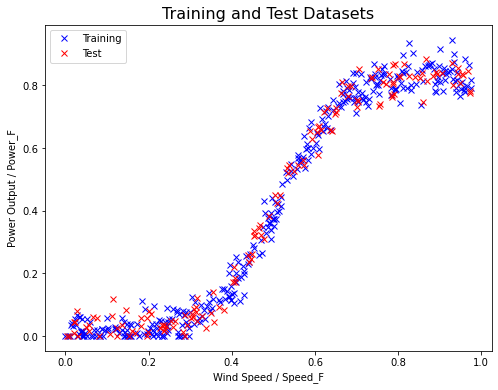

In [35]:

# Plot of training and test data
plt.plot(train['speed'], train['power'], 'bx', label='Training')
plt.plot(test['speed'], test['power'], 'rx', label='Test')
plt.title("Training and Test Datasets", fontsize = 16)
plt.xlabel("Wind Speed / Speed_F")
plt.ylabel("Power Output / Power_F")
plt.legend();


<B>Applying Keras Model</B>


In [36]:
#code adopted from https://stackabuse.com/deep-learning-in-keras-building-a-deep-learning-model/
# Need x and y in correct format.
X = Power_data[["speed"]] # note dimensions
y = Power_data["power"]

# Split the data set into train/set. 80:20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Take some of the training set to be a validation set. 25% of 80 = 60 
# Want train:test:validation = 60:20:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(291, 1)
(291,)
(98, 1)
(98,)
(97, 1)
(97,)


In [37]:
# Create basic Keras main model Code adpted from https://stackoverflow.com/a/59148584
model = kr.models.Sequential()
# Add 1st Hidden layer
model.add(kr.layers.Dense(10, input_shape=(1,), activation="sigmoid", kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# Add 2nd Hidden layer
model.add(kr.layers.Dense(10, activation="sigmoid", kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# Add Output layer
model.add(kr.layers.Dense(1, activation="sigmoid", kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# Compile model
model.compile('adam', loss='mean_squared_error')
print("Keras Main Model Summary")
print("============================")
model.summary()
#https://stackoverflow.com/questions/55049208/error-in-loading-the-model-with-load-weights-in-keras

#model.load_weights("Model_NN.h5")


Keras Main Model Summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


Once the model is designed, we must compile it to specify the learning rate and loss function, the quantity we are trying to minimize in through training of the network.

In [38]:
# Train the Keras main model on the training dataset.
history = model.fit(train['speed'], train['power'], epochs=500, batch_size=10)

Epoch 1/500
34/34 [==============================] - 0s 424us/step - loss: 0.1627
Epoch 2/500
34/34 [==============================] - 0s 394us/step - loss: 0.1377
Epoch 3/500
34/34 [==============================] - 0s 394us/step - loss: 0.1334
Epoch 4/500
34/34 [==============================] - 0s 394us/step - loss: 0.1252
Epoch 5/500
34/34 [==============================] - 0s 424us/step - loss: 0.1232
Epoch 6/500
34/34 [==============================] - 0s 394us/step - loss: 0.1240
Epoch 7/500
34/34 [==============================] - 0s 394us/step - loss: 0.1230
Epoch 8/500
34/34 [==============================] - 0s 394us/step - loss: 0.1191
Epoch 9/500
34/34 [==============================] - 0s 394us/step - loss: 0.1279
Epoch 10/500
34/34 [==============================] - 0s 394us/step - loss: 0.1185
Epoch 11/500
34/34 [==============================] - 0s 394us/step - loss: 0.1183
Epoch 12/500
34/34 [==============================] - 0s 394us/step - loss: 0.1175
Epoch 13/500


34/34 [==============================] - 0s 394us/step - loss: 0.0027
Epoch 100/500
34/34 [==============================] - 0s 394us/step - loss: 0.0025
Epoch 101/500
34/34 [==============================] - 0s 394us/step - loss: 0.0025
Epoch 102/500
34/34 [==============================] - 0s 424us/step - loss: 0.0025
Epoch 103/500
34/34 [==============================] - 0s 394us/step - loss: 0.0026
Epoch 104/500
34/34 [==============================] - 0s 394us/step - loss: 0.0025
Epoch 105/500
34/34 [==============================] - 0s 394us/step - loss: 0.0024
Epoch 106/500
34/34 [==============================] - 0s 394us/step - loss: 0.0025
Epoch 107/500
34/34 [==============================] - 0s 394us/step - loss: 0.0025
Epoch 108/500
34/34 [==============================] - 0s 394us/step - loss: 0.0026
Epoch 109/500
34/34 [==============================] - 0s 394us/step - loss: 0.0026
Epoch 110/500
34/34 [==============================] - 0s 424us/step - loss: 0.0024
Epoch 

34/34 [==============================] - 0s 424us/step - loss: 0.0019
Epoch 197/500
34/34 [==============================] - 0s 394us/step - loss: 0.0016
Epoch 198/500
34/34 [==============================] - 0s 424us/step - loss: 0.0017
Epoch 199/500
34/34 [==============================] - 0s 455us/step - loss: 0.0017
Epoch 200/500
34/34 [==============================] - 0s 394us/step - loss: 0.0016
Epoch 201/500
34/34 [==============================] - 0s 424us/step - loss: 0.0016
Epoch 202/500
34/34 [==============================] - 0s 394us/step - loss: 0.0016
Epoch 203/500
34/34 [==============================] - 0s 424us/step - loss: 0.0016
Epoch 204/500
34/34 [==============================] - 0s 364us/step - loss: 0.0018
Epoch 205/500
34/34 [==============================] - 0s 394us/step - loss: 0.0017
Epoch 206/500
34/34 [==============================] - 0s 424us/step - loss: 0.0017
Epoch 207/500
34/34 [==============================] - 0s 424us/step - loss: 0.0014
Epoch 

34/34 [==============================] - 0s 424us/step - loss: 0.0015
Epoch 294/500
34/34 [==============================] - 0s 424us/step - loss: 0.0016
Epoch 295/500
34/34 [==============================] - 0s 424us/step - loss: 0.0014
Epoch 296/500
34/34 [==============================] - 0s 424us/step - loss: 0.0013
Epoch 297/500
34/34 [==============================] - 0s 424us/step - loss: 0.0014
Epoch 298/500
34/34 [==============================] - 0s 394us/step - loss: 0.0014
Epoch 299/500
34/34 [==============================] - 0s 394us/step - loss: 0.0015
Epoch 300/500
34/34 [==============================] - 0s 394us/step - loss: 0.0015
Epoch 301/500
34/34 [==============================] - 0s 394us/step - loss: 0.0015
Epoch 302/500
34/34 [==============================] - 0s 394us/step - loss: 0.0014
Epoch 303/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013
Epoch 304/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013
Epoch 

34/34 [==============================] - 0s 394us/step - loss: 0.0014
Epoch 391/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013
Epoch 392/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013
Epoch 393/500
34/34 [==============================] - 0s 424us/step - loss: 0.0015
Epoch 394/500
34/34 [==============================] - 0s 424us/step - loss: 0.0011
Epoch 395/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013
Epoch 396/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013
Epoch 397/500
34/34 [==============================] - 0s 394us/step - loss: 0.0015
Epoch 398/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013
Epoch 399/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013
Epoch 400/500
34/34 [==============================] - 0s 394us/step - loss: 0.0012
Epoch 401/500
34/34 [==============================] - 0s 394us/step - loss: 0.0016
Epoch 

34/34 [==============================] - 0s 394us/step - loss: 0.0016
Epoch 488/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013
Epoch 489/500
34/34 [==============================] - 0s 424us/step - loss: 0.0013
Epoch 490/500
34/34 [==============================] - 0s 394us/step - loss: 0.0014
Epoch 491/500
34/34 [==============================] - 0s 424us/step - loss: 0.0013
Epoch 492/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013
Epoch 493/500
34/34 [==============================] - 0s 394us/step - loss: 0.0013
Epoch 494/500
34/34 [==============================] - 0s 364us/step - loss: 0.0014
Epoch 495/500
34/34 [==============================] - 0s 394us/step - loss: 0.0014
Epoch 496/500
34/34 [==============================] - 0s 394us/step - loss: 0.0014
Epoch 497/500
34/34 [==============================] - 0s 424us/step - loss: 0.0013
Epoch 498/500
34/34 [==============================] - 0s 394us/step - loss: 0.0012
Epoch 

In [25]:
# Compile the model and summarize it.
model.compile(kr.optimizers.Adam(lr=0.001), loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


The hidden layer has 50 neurons plus 50 bias terms giving 100 parameters for this layer. The output layer has 1 neuron with one bias term and 50 inputs feeding to it, so 51 parameters in total. The network has 151 parameters. The aim is to train it and find good values for these 151 parameters. 

In [39]:
print(f"The final scaled Mean Squared Error cost/loss factor in the Keras main model training dataset is {history.history['loss'][-1]}")

The final scaled Mean Squared Error cost/loss factor in the Keras main model training dataset is 0.0013243431458249688


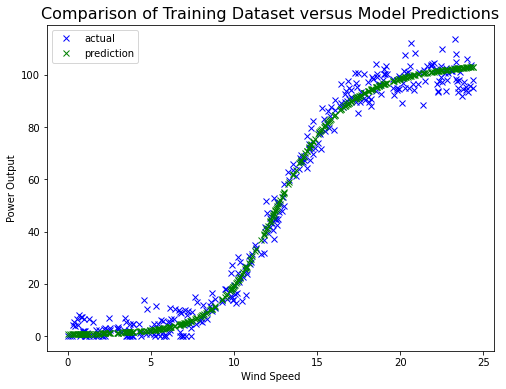

In [42]:
# Plot training dataset comparison
plt.plot(train['speed']*Speed_F, train['power']*Power_F, 'bx', label='actual')
plt.plot(train['speed']*Speed_F, model.predict(train['speed'])*Power_F, 'gx', label='prediction')
plt.title("Comparison of Training Dataset versus Model Predictions", fontsize = 16)
plt.xlabel("Wind Speed")
plt.ylabel("Power Output")
plt.legend();

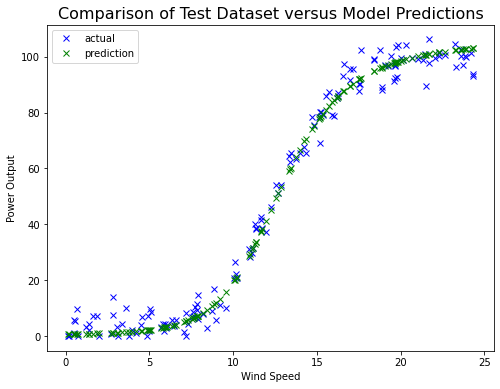

In [44]:
# Plot testing dataset comparison
plt.plot(test['speed']*Speed_F, test['power']*Power_F, 'bx', label='actual')
plt.plot(test['speed']*Speed_F, model.predict(test['speed'])*Power_F, 'gx', label='prediction')
plt.title("Comparison of Test Dataset versus Model Predictions", fontsize = 16)
plt.xlabel("Wind Speed")
plt.ylabel("Power Output")
plt.legend();

In [50]:
# Testing of the model prediction
print(f"Wind speed of 20 using the Keras Main model gives power of: {round(model.predict([20/Speed_F])[0][0]*Power_F, 3)}")

Wind speed of 20 using the Keras Main model gives power of: 98.532


In [51]:
# Predict from a single input value - seems sensible.
wind = [[20]]
print(model.predict(wind))

[[0.8852189]]


<b>Save the Neural Network Model</b>

In [52]:
model.save("Model_NN.h5")
print("Neural network model saved as Model_NN.h5")

Neural network model saved as Model_NN.h5


In [53]:
# serialize model to JSON
model_json = model.to_json()
with open("Model_NN.json", "w") as json_file:
    json_file.write(model_json)
print("Neural network model saved as Model_NN.json")

Neural network model saved as Model_NN.json


References:

[1]. The Power of the Wind: Cube of Wind Speed, http://xn--drmstrre-64ad.dk/wp-content/wind/miller/windpower%20web/en/tour/wres/enrspeed.htm

[2]. The Power Curve of a Wind Turbine, http://xn--drmstrre-64ad.dk/wp-content/wind/miller/windpower%20web/en/tour/wres/pwr.htm

[3]. Wind Turbine Power Curve, https://www.windfarmbop.com/wind-power-plant-concepts-and-performance-indicators/wind-turbine-power-curve/

[4]. How Do Wind Turbines Survive Severe Storms?; Office of ENERGY EFFICIENCY & RENEWABLE ENERGY - USA; https://www.energy.gov/eere/articles/how-do-wind-turbines-survive-severe-storms

[5].Simple Linear Regression, https://towardsdatascience.com/linear-regression-using-python-b136c91bf0a2

[6] Machine learning methods for wind turbine condition monitoring: A review, https://www.sciencedirect.com/science/article/pii/S096014811831231X
[6] Deep Learning, https://stackabuse.com/deep-learning-in-keras-building-a-deep-learning-model/ 

[7] Machine Learning Mastery, How To Build Multi-Layer Perceptron Neural Network Models with Keras , https://machinelearningmastery.com/build-multi-layer-perceptron-neural-network-models-keras/

[] Data Cleaning Challenge: Scale and Normalize Data, https://www.kaggle.com/rtatman/data-cleaning-challenge-scale-and-normalize-data


[].  Machine learning methods for wind turbine condition monitoring: A review,  https://www.sciencedirect.com/science/article/pii/S096014811831231X

[]

